<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Econ-442B-Machine-Learning-Forecast-Project" data-toc-modified-id="Econ-442B-Machine-Learning-Forecast-Project-0.1"><center>Econ 442B Machine Learning Forecast Project</center></a></span></li></ul></li><li><span><a href="#Creating-Dataset" data-toc-modified-id="Creating-Dataset-1"><center>Creating Dataset</center></a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Forecasting-SPY" data-toc-modified-id="Forecasting-SPY-1.0.1"><center>Forecasting SPY</center></a></span></li><li><span><a href="#Using-the-following-Predictors:" data-toc-modified-id="Using-the-following-Predictors:-1.0.2"><center>Using the following Predictors:</center></a></span></li><li><span><a href="#Dollar-Index-(Dixie)" data-toc-modified-id="Dollar-Index-(Dixie)-1.0.3"><center>Dollar Index (Dixie)</center></a></span></li><li><span><a href="#VIX" data-toc-modified-id="VIX-1.0.4"><center>VIX</center></a></span></li><li><span><a href="#Breakeven-Inflation" data-toc-modified-id="Breakeven-Inflation-1.0.5"><center>Breakeven Inflation</center></a></span></li><li><span><a href="#Federal-Funds-Rate" data-toc-modified-id="Federal-Funds-Rate-1.0.6"><center>Federal Funds Rate</center></a></span></li></ul></li><li><span><a href="#Target-Function-of-Choice-is:-Sharpe-Ratio" data-toc-modified-id="Target-Function-of-Choice-is:-Sharpe-Ratio-1.1"><center>Target Function of Choice is: Sharpe Ratio</center></a></span></li><li><span><a href="#-Split-Data-Into-Three-Parts" data-toc-modified-id="-Split-Data-Into-Three-Parts-1.2"><center> Split Data Into Three Parts</center></a></span></li><li><span><a href="#--Produce-a-Heat-Map-of-Hyperparameters" data-toc-modified-id="--Produce-a-Heat-Map-of-Hyperparameters-1.3"><center>  Produce a Heat Map of Hyperparameters</center></a></span></li><li><span><a href="#-Evaluate-model-performance-for-the-⅔-of-the-data-choose-optimal-parameters/hyper-parameters-using-⅔-of-data" data-toc-modified-id="-Evaluate-model-performance-for-the-⅔-of-the-data-choose-optimal-parameters/hyper-parameters-using-⅔-of-data-1.4"><center> Evaluate model performance for the ⅔ of the data choose optimal parameters/hyper-parameters using ⅔ of data</center></a></span></li></ul></li></ul></div>

## <center>Econ 442B Machine Learning Forecast Project

# <center>Creating Dataset

### <center>Forecasting SPY 

### <center>Using the following Predictors:
### <center>Dollar Index (Dixie)
### <center>VIX
### <center>Breakeven Inflation
### <center>Federal Funds Rate

In [1]:
# Load Necessary Packages and establish working directory
import os
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from scipy.stats import skew
from statistics import mean
from statistics import stdev
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import seaborn as sns
import datetime
import numpy as np 
from numpy.random import seed
import scipy.stats as st
import warnings
warnings.simplefilter(action='ignore')
import random, heapq
import tensorflow as tf


In [2]:
# Loading dataset
# Read the required data to prep for analysis
Data = pd.ExcelFile('Dataset_442B.xlsx')
Data= pd.read_excel(Data)
Data.head()

,Date,SPY,DIXIE,VIX,BREAK,RATE
0,2003-01-01,60.379791,4.10,31.170000,1.76,1.24
1,2003-02-01,59.565929,3.87,29.629999,1.91,1.26
2,2003-03-01,59.453651,2.99,29.150000,1.87,1.25
3,2003-04-01,64.744141,2.99,21.209999,1.78,1.26
4,2003-05-01,68.294456,3.25,19.469999,1.66,1.26


In [3]:
# Changing variables to represent returns
Data["SPY_Change"] = Data["SPY"].pct_change()
Data.dropna(inplace=True)

# Dropped SPY
Data = Data.drop(columns=["SPY"])

# Change Index to Datetime
datetime_series = pd.to_datetime(Data['Date'])
datetime_index = pd.DatetimeIndex(datetime_series.values)
Data = Data.set_index(datetime_index)
Data = Data.drop(columns=["Date"])

# Reordering columns
Data = pd.DataFrame(Data, columns = ["SPY_Change", "DIXIE", "VIX", "BREAK","RATE"])
Data.head()

,SPY_Change,DIXIE,VIX,BREAK,RATE
2003-02-01,-0.013479,3.87,29.629999,1.91,1.26
2003-03-01,-0.001885,2.99,29.150000,1.87,1.25
2003-04-01,0.088985,2.99,21.209999,1.78,1.26
2003-05-01,0.054836,3.25,19.469999,1.66,1.26
2003-06-01,0.007014,3.44,19.520000,1.61,1.22


## <center>Target Function of Choice is: Sharpe Ratio

The Sharpe ratio was developed by Nobel laureate William F. Sharpe and is used to help investors understand the return of an investment compared to its risk.The ratio is the average return earned in excess of the risk-free rate per unit of volatility or total risk. Volatility is a measure of the price fluctuations of an asset or portfolio.

Generally, the greater the value of the Sharpe ratio, the more attractive the risk-adjusted return.

The greater a portfolio's Sharpe ratio, the better its risk-adjusted-performance. If the analysis results in a negative Sharpe ratio, it either means the risk-free rate is greater than the portfolio’s return, or the portfolio's return is expected to be negative. In either case, a negative Sharpe ratio does not convey any useful meaning.

Sharpe Ratios above 1.00 are generally considered “good”, as this would suggest that the portfolio is offering excess returns relative to its volatility. Having said that, investors will often compare the Sharpe Ratio of a portfolio relative to its peers. Therefore, a portfolio with a Sharpe Ratio of 1.00 might be considered inadequate if the competitors in its peer group have an average Sharpe Ratio above 1.00.

In [4]:
# Target Function: Sharpe Ratio

def sharpe_ratio(returns, rfr):
    excess_returns = returns - rfr
    n = len(excess_returns)
    mean = excess_returns.mean()
    std = np.sqrt(np.sum(np.square(excess_returns-mean))/(n-1))
    return(mean/std)

In [5]:
# Model: RNN

def sequentialize(asset):
    d = asset.copy()
    X = d.iloc[:,1:]
    Y = d.iloc[:,0]

    input_sequences = []
    y = []
    obs = d.shape[0]

    for i in range(WINDOW, obs):
        input_sequences.append(X.iloc[i-WINDOW:i,:])
        y.append(Y.iloc[i])

    input_sequences = np.array(input_sequences)
    y = np.array(y)
    return(input_sequences, y)

def my_RNN(asset, WINDOW, LAYERS):
    d = asset.copy()
    (input_sequences, y) = sequentialize(d)
    
    rnn = Sequential()

    rnn.add(LSTM(units = 30, return_sequences=True, 
                 input_shape =  input_sequences[0].shape))
    rnn.add(Dropout(.2))

    for i in range(LAYERS):
        rnn.add(LSTM(units = 30, return_sequences=True))
        rnn.add(Dropout(.2))

    rnn.add(LSTM(units = 30, return_sequences=False))

    rnn.add(Dense(units = 1))

    rnn.compile(optimizer = 'adam', loss = 'mean_squared_error')

    rnn.fit(input_sequences, y, epochs = 15, batch_size = 32)
    return(rnn)

def evaluate(asset, rnn, input_sequences, WINDOW):
    d = asset.copy()
    pred = rnn.predict(input_sequences)
    asset_c = d.iloc[WINDOW:,:]
    asset_c["Preds"] = pred
    asset_c["Returns"] = 0.
    asset_c["Returns"][asset_c["Preds"] > 0] = asset_c["SPY_Change"]
    asset_c["Returns"][asset_c["Preds"] < 0] = -asset_c["SPY_Change"]
    return(asset_c[["Returns"]])

In [14]:
# Set random state
random.seed(442)
seed(442)
tf.random.set_seed(442)

WINDOW = 20
LAYERS = 1
asset = Data.copy()

rnn = my_RNN(asset, WINDOW, LAYERS)
(input_sequences, y ) = sequentialize(asset)
R = evaluate(asset, rnn, input_sequences, WINDOW)

Epoch 1/15
7/7 [==============================] - 5s 35ms/step - loss: 0.0086
Epoch 2/15
7/7 [==============================] - 0s 28ms/step - loss: 0.0027
Epoch 3/15
7/7 [==============================] - 0s 30ms/step - loss: 0.0027
Epoch 4/15
7/7 [==============================] - 0s 31ms/step - loss: 0.0024
Epoch 5/15
7/7 [==============================] - 0s 32ms/step - loss: 0.0023
Epoch 6/15
7/7 [==============================] - 0s 31ms/step - loss: 0.0021
Epoch 7/15
7/7 [==============================] - 0s 32ms/step - loss: 0.0019
Epoch 8/15
7/7 [==============================] - 0s 30ms/step - loss: 0.0022
Epoch 9/15
7/7 [==============================] - 0s 29ms/step - loss: 0.0020
Epoch 10/15
7/7 [==============================] - 0s 31ms/step - loss: 0.0021
Epoch 11/15
7/7 [==============================] - 0s 33ms/step - loss: 0.0016
Epoch 12/15
7/7 [==============================] - 0s 26ms/step - loss: 0.0017
Epoch 13/15
7/7 [==============================] - 0s 29ms/st

In [15]:
# Calculate Sharpe Ratio based on a risk free rate of 1%
monthly_risk_free_rate = 1.01**(1/12)-1
sharpe_ratio(pd.DataFrame(R),monthly_risk_free_rate)

Returns    0.092324
dtype: float64

<br>

So we can see here, with WINDOW=20 and LAYERS=1, the Sharpe Ratio for our asset is 0.092324. And now we will split out data into three parts and apply different sets of hyperparameters and choose the best one.

## <center> Split Data Into Three Parts

In [6]:
split = len(Data) // 3
Data_sect1 = Data.iloc[:split,:]
Data_sect2 = Data.iloc[split:2*split,:]
Data_sect3 = Data.iloc[2*split:,:]

## <center>  Produce a Heat Map of Hyperparameters

In [17]:
ts = [10,20,30,40,50] # WINDOW
hs = [1,2,3]  # LAYERS

# Initialize Data frame to record results for heatmap
evaluation_Sharpe = pd.DataFrame(np.zeros((len(ts), len(hs))), index = ts, columns = hs)

In [18]:
# Loop over hyperparameters and record Sharpe ratio
for n, WINDOW in enumerate(ts):
    for m , LAYERS in enumerate(hs):
        asset = Data_sect1.copy()
        
        # Set random state
        random.seed(442)
        seed(442)
        tf.random.set_seed(442)
        
        rnn = my_RNN(asset, WINDOW, LAYERS)
        (input_sequences, y ) = sequentialize(asset)
        R = evaluate(asset, rnn, input_sequences, WINDOW)
        Sharpe = sharpe_ratio(pd.DataFrame(R), monthly_risk_free_rate)[0]
        evaluation_Sharpe.iloc[n,m] = Sharpe    

Epoch 1/15
2/2 [==============================] - 4s 19ms/step - loss: 0.0063
Epoch 2/15
2/2 [==============================] - 0s 22ms/step - loss: 0.0033
Epoch 3/15
2/2 [==============================] - 0s 23ms/step - loss: 0.0034
Epoch 4/15
2/2 [==============================] - 0s 25ms/step - loss: 0.0021
Epoch 5/15
2/2 [==============================] - 0s 26ms/step - loss: 0.0018
Epoch 6/15
2/2 [==============================] - 0s 21ms/step - loss: 0.0018
Epoch 7/15
2/2 [==============================] - 0s 17ms/step - loss: 0.0016
Epoch 8/15
2/2 [==============================] - 0s 18ms/step - loss: 0.0020
Epoch 9/15
2/2 [==============================] - 0s 24ms/step - loss: 0.0017
Epoch 10/15
2/2 [==============================] - 0s 24ms/step - loss: 0.0016
Epoch 11/15
2/2 [==============================] - 0s 17ms/step - loss: 0.0012
Epoch 12/15
2/2 [==============================] - 0s 14ms/step - loss: 0.0011
Epoch 13/15
2/2 [==============================] - 0s 17ms/st

Epoch 1/15
1/1 [==============================] - 4s 4s/step - loss: 0.0058
Epoch 2/15
1/1 [==============================] - 0s 61ms/step - loss: 0.0041
Epoch 3/15
1/1 [==============================] - 0s 58ms/step - loss: 0.0048
Epoch 4/15
1/1 [==============================] - 0s 53ms/step - loss: 0.0028
Epoch 5/15
1/1 [==============================] - 0s 54ms/step - loss: 0.0021
Epoch 6/15
1/1 [==============================] - 0s 51ms/step - loss: 0.0023
Epoch 7/15
1/1 [==============================] - 0s 49ms/step - loss: 0.0033
Epoch 8/15
1/1 [==============================] - 0s 50ms/step - loss: 0.0023
Epoch 9/15
1/1 [==============================] - 0s 43ms/step - loss: 0.0025
Epoch 10/15
1/1 [==============================] - 0s 41ms/step - loss: 0.0018
Epoch 11/15
1/1 [==============================] - 0s 48ms/step - loss: 0.0019
Epoch 12/15
1/1 [==============================] - 0s 48ms/step - loss: 0.0017
Epoch 13/15
1/1 [==============================] - 0s 52ms/step

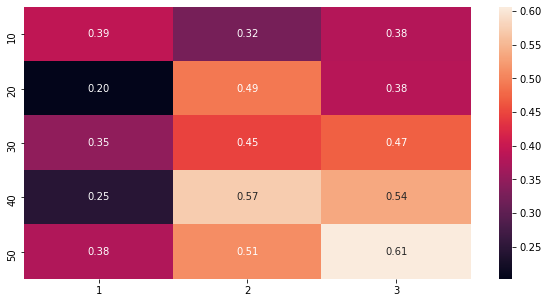

In [19]:
plt.subplots(figsize = (10, 5))
sns.heatmap(evaluation_Sharpe, annot =True, fmt=".2f")
plt.show()

<br>

So our heatmap gives us some interestig findings:

* Holding LAYERS constant, the Sharpe Ratio for different WINDOWS doesn't seem to have some pattern. When LAYER=1, the Sharpe Ratio is just reverting around while LAYERS=2, it seems to reach the highest value at WINDOWS=40 and begin to decrease. But for LAYERS at 3, we can see that the highest ratio is 0.61 when WINDOWS=50.


* Holding WINDOWS constant, overall speaking, the Sharpe Ratio is higher for larger number of LAYERS. But we can still see some abnormal outcome.


* In conlusion, we will choose WINDOWS=50 and LAYERS=3 to be our best model using the whole data.


In [20]:
W_1 = 50
L_1 = 3

## <center> Evaluate model performance for the ⅔ of the data choose optimal parameters/hyper-parameters using ⅔ of data 

In [22]:
asset = Data_sect1.copy()
rnn = my_RNN(asset, W_1, L_1)

# Two thirds of the data
twothirds = pd.concat([Data_sect2, Data_sect3])
asset = twothirds.copy()

# Set random state
random.seed(442)
seed(442)
tf.random.set_seed(442)
        
(input_sequences, y) = sequentialize(asset)
R = evaluate(asset, rnn, input_sequences, WINDOW)
Sharpe = sharpe_ratio(pd.DataFrame(R), monthly_risk_free_rate)[0]

Epoch 1/15
1/1 [==============================] - 8s 8s/step - loss: 0.0132
Epoch 2/15
1/1 [==============================] - 0s 142ms/step - loss: 0.0029
Epoch 3/15
1/1 [==============================] - 0s 143ms/step - loss: 0.0055
Epoch 4/15
1/1 [==============================] - 0s 133ms/step - loss: 0.0056
Epoch 5/15
1/1 [==============================] - 0s 116ms/step - loss: 0.0030
Epoch 6/15
1/1 [==============================] - 0s 121ms/step - loss: 0.0026
Epoch 7/15
1/1 [==============================] - 0s 117ms/step - loss: 0.0033
Epoch 8/15
1/1 [==============================] - 0s 130ms/step - loss: 0.0039
Epoch 9/15
1/1 [==============================] - 0s 123ms/step - loss: 0.0047
Epoch 10/15
1/1 [==============================] - 0s 122ms/step - loss: 0.0024
Epoch 11/15
1/1 [==============================] - 0s 114ms/step - loss: 0.0027
Epoch 12/15
1/1 [==============================] - 0s 115ms/step - loss: 0.0024
Epoch 13/15
1/1 [==============================] - 0

In [23]:
print("In Sample Sharpe Ratio : ", evaluation_Sharpe.max().max())
print("Out of Sample Sharpe Ratio : ", Sharpe)

In Sample Sharpe Ratio :  0.6063715869590461
Out of Sample Sharpe Ratio :  -0.33198408858560313


<br>

We chose the optimal hyperparameters from the whole data and apply it to the first one-third of the data and come up with the model. Then use the model to evaluate the other two-thirds of the data.

But it seems is not performing well on the two-thirds part of our data because of the negative value of Sharpe Ratio. It indicates under our model set, this part of data doesn't return profit higher than market riks free rate with the given model, also indicating that the first one-third of the data is quite different from the other two-thirds part. So we shall try using this part of data to select optimal model.

In [8]:
evaluation_Sharpe2 = pd.DataFrame(np.zeros((len(ts), len(hs))), index = ts, columns = hs)

In [11]:
twothirds = pd.concat([Data_sect2, Data_sect3])
asset = twothirds.copy()
monthly_risk_free_rate = 1.01**(1/12)-1

for n, WINDOW in enumerate(ts):
    for m , LAYERS in enumerate(hs):
        asset = twothirds.copy()
        
        # Set random state
        random.seed(442)
        seed(442)
        tf.random.set_seed(442)
        
        rnn = my_RNN(asset, WINDOW, LAYERS)
        (input_sequences, y ) = sequentialize(asset)
        R = evaluate(asset, rnn, input_sequences, WINDOW)
        Sharpe = sharpe_ratio(pd.DataFrame(R), monthly_risk_free_rate)[0]
        evaluation_Sharpe2.iloc[n,m] = Sharpe

Epoch 1/15
5/5 [==============================] - 15s 27ms/step - loss: 0.0060
Epoch 2/15
5/5 [==============================] - 0s 31ms/step - loss: 0.0033
Epoch 3/15
5/5 [==============================] - 0s 27ms/step - loss: 0.0025
Epoch 4/15
5/5 [==============================] - 0s 29ms/step - loss: 0.0026
Epoch 5/15
5/5 [==============================] - 0s 27ms/step - loss: 0.0020
Epoch 6/15
5/5 [==============================] - 0s 29ms/step - loss: 0.0020
Epoch 7/15
5/5 [==============================] - 0s 27ms/step - loss: 0.0019
Epoch 8/15
5/5 [==============================] - 0s 29ms/step - loss: 0.0017
Epoch 9/15
5/5 [==============================] - 0s 28ms/step - loss: 0.0018
Epoch 10/15
5/5 [==============================] - 0s 29ms/step - loss: 0.0021
Epoch 11/15
5/5 [==============================] - 0s 31ms/step - loss: 0.0018
Epoch 12/15
5/5 [==============================] - 0s 29ms/step - loss: 0.0020
Epoch 13/15
5/5 [==============================] - 0s 31ms/s

4/4 [==============================] - 0s 69ms/step - loss: 0.0015
Epoch 1/15
4/4 [==============================] - 19s 101ms/step - loss: 0.0038
Epoch 2/15
4/4 [==============================] - 0s 90ms/step - loss: 0.0029
Epoch 3/15
4/4 [==============================] - 0s 90ms/step - loss: 0.0019
Epoch 4/15
4/4 [==============================] - 0s 88ms/step - loss: 0.0024
Epoch 5/15
4/4 [==============================] - 0s 88ms/step - loss: 0.0017
Epoch 6/15
4/4 [==============================] - 0s 92ms/step - loss: 0.0022
Epoch 7/15
4/4 [==============================] - 0s 94ms/step - loss: 0.0018
Epoch 8/15
4/4 [==============================] - 0s 90ms/step - loss: 0.0019
Epoch 9/15
4/4 [==============================] - 0s 89ms/step - loss: 0.0018
Epoch 10/15
4/4 [==============================] - 0s 90ms/step - loss: 0.0016
Epoch 11/15
4/4 [==============================] - 0s 88ms/step - loss: 0.0016
Epoch 12/15
4/4 [==============================] - 0s 87ms/step - loss:

3/3 [==============================] - 0s 108ms/step - loss: 0.0018
Epoch 14/15
3/3 [==============================] - 0s 113ms/step - loss: 0.0016
Epoch 15/15
3/3 [==============================] - 0s 109ms/step - loss: 0.0018
Epoch 1/15
3/3 [==============================] - 9s 34ms/step - loss: 0.0037
Epoch 2/15
3/3 [==============================] - 0s 31ms/step - loss: 0.0042
Epoch 3/15
3/3 [==============================] - 0s 31ms/step - loss: 0.0017
Epoch 4/15
3/3 [==============================] - 0s 36ms/step - loss: 0.0019
Epoch 5/15
3/3 [==============================] - 0s 32ms/step - loss: 0.0016
Epoch 6/15
3/3 [==============================] - 0s 31ms/step - loss: 0.0021
Epoch 7/15
3/3 [==============================] - 0s 31ms/step - loss: 0.0017
Epoch 8/15
3/3 [==============================] - 0s 30ms/step - loss: 0.0019
Epoch 9/15
3/3 [==============================] - 0s 30ms/step - loss: 0.0016
Epoch 10/15
3/3 [==============================] - 0s 30ms/step - loss

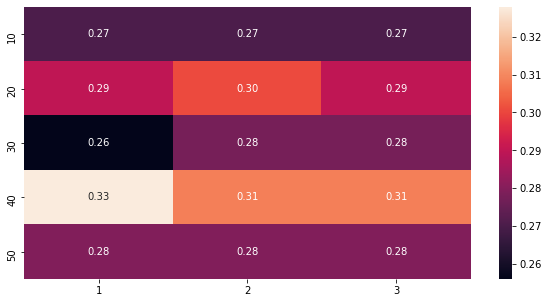

In [12]:
plt.subplots(figsize = (10, 5))
sns.heatmap(evaluation_Sharpe2, annot=True, fmt=".2f")
plt.show()

Very similar results irrespective of hyperparameters.